In [1]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import aptwrapper
import numpy as np
import matplotlib.pyplot as plt
import pickle
from ipywidgets import widgets
from skimage import segmentation
import pandas as pd

metadata = pickle.load(open('./cache/metadata.pkl', 'rb'))
spectra = pickle.load(open('./cache/spectra_veven_raw.pkl', 'rb'))
spectra_vodd = pickle.load(open('./cache/spectra_vodd_raw.pkl', 'rb'))
maps = pickle.load(open('./cache/maps_raw.pkl', 'rb'))
maps_aligned = pickle.load(open('./cache/maps_aligned.pkl', 'rb'))
celltable = pickle.load(open('./cache/celltable.pkl', 'rb'))
ibtable = pickle.load(open('./cache/ibtable.pkl', 'rb'))

# Size of dataset

In [2]:
print('num cells:',   len(celltable))
print('num ibs:',     len(ibtable))
print('num spectra:', len(spectra.si) + len(spectra_vodd.si))
print('num samples:', celltable.sample_id.nunique())

num cells: 12361
num ibs: 3398
num spectra: 1418
num samples: 53


In [3]:
spectra.isel(v=0).to_dataframe().groupby('feature').v.count()

feature
bg    344
cp    454
ib    440
Name: v, dtype: int64

# IB size

WT Repeats

In [4]:
(ibtable
#  .groupby('experiment')
 .query('experiment == "wt_repeats"')
 .assign(
     r_px=lambda x: np.sqrt(x.ib_area_px / np.pi),
     r=lambda x: np.sqrt(x.ib_area / np.pi)
 )
 [['ib_area_px', 'ib_area', 'r_px', 'r']]
 .aggregate(['mean', 'std', 'median', 'min'])
)

,ib_area_px,ib_area,r_px,r
mean,69.898955,0.026661,4.356047,0.085073
std,60.108936,0.022929,1.812687,0.035403
median,52.000000,0.019836,4.068429,0.079462
min,13.000000,0.004959,2.034214,0.039731


Recovery timeline

In [5]:
(ibtable
#  .groupby('experiment')
 .query('experiment == "recovery_timeline"')
 .assign(
     r_px=lambda x: np.sqrt(x.ib_area_px / np.pi),
     r=lambda x: np.sqrt(x.ib_area / np.pi)
 )
 [['ib_area_px', 'ib_area', 'r_px', 'r']]
 .aggregate(['mean', 'std', 'median', 'min'])
)

,ib_area_px,ib_area,r_px,r
mean,34.900769,0.053254,3.191691,0.124675
std,22.231632,0.033923,0.960577,0.037523
median,29.000000,0.044250,3.038254,0.118682
min,13.000000,0.019836,2.034214,0.079462


# Check wavenumbers without contrast

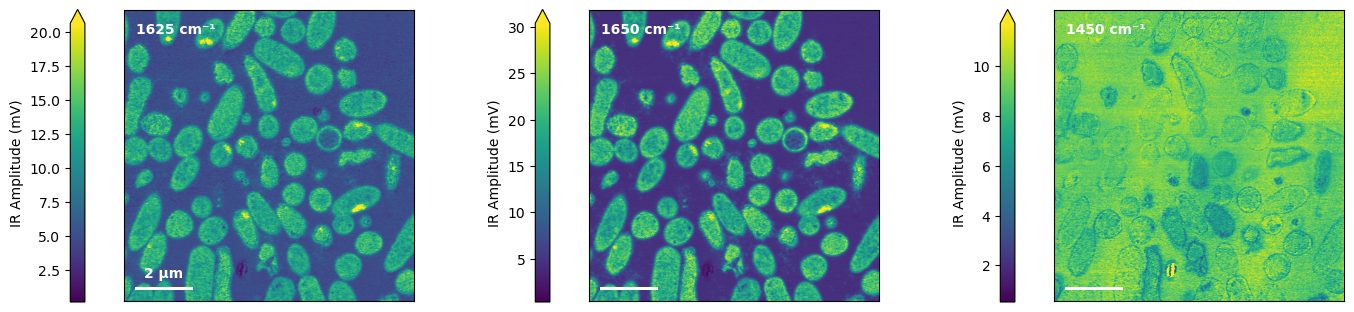

In [6]:
doc = aptwrapper.read('../primary_data/fig2_wt_repeats/extra_repeats/2024-05-29_TB011J_WTB_localisation_maps_spectra_and_extra.axz')
fig, ax = plt.subplots(1, 3, figsize=(17,3.8))
aptwrapper.plot_map(doc.HeightMaps['IR Amplitude 6'], ax[0], vmax=np.percentile(doc.HeightMaps['IR Amplitude 6'], 99.9), vmin=0, show_sb_val=1)
aptwrapper.plot_map(doc.HeightMaps['IR Amplitude 5'], ax[1], vmax=np.percentile(doc.HeightMaps['IR Amplitude 5'], 99.9), vmin=0, show_sb_val=0)#, cb_label='')
aptwrapper.plot_map(doc.HeightMaps['IR Amplitude 7'], ax[2], vmax=np.percentile(doc.HeightMaps['IR Amplitude 7'], 99.9), vmin=0, show_sb_val=0)#, cb_label='')

fig.savefig('../figures/supp_ctrl_wavenumber.eps', bbox_inches='tight')

# Map alignment and segmentation

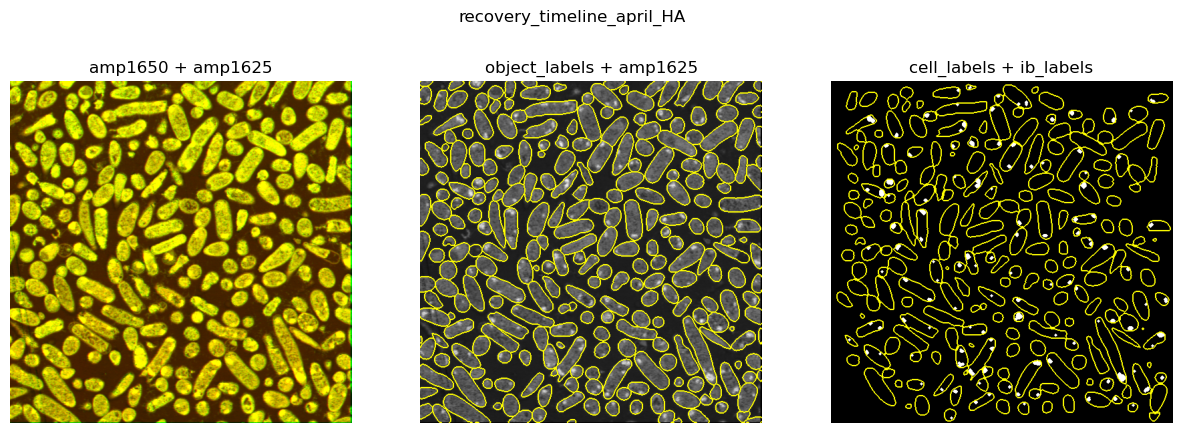

In [7]:
dataset_ids_by_experiment = {
    e: [im.dataset_id.item() for im in maps_aligned.values() if im.experiment.item() == e]
    for e in metadata.experiment.unique()
}

# w_experiments = widgets.Dropdown(options=dataset_ids_by_experiment.keys())
# w_datasets = widgets.Dropdown(options=dataset_ids_by_experiment[w_experiments.value])

# @widgets.interact(experiment=w_experiments, dataset=w_datasets)
def plot_segmentation_qc(experiment, dataset):
    
    # # Update widget options
    # valid_options = dataset_ids_by_experiment[experiment]
    # if w_datasets.value not in valid_options:
    #     w_datasets.options = valid_options
    #     return
        
    # Image processing
    def image_to_rgb(image):
        def norm_to_percentile(x, p):
            max = np.nanpercentile(x, p)
            return np.clip(x/max, 0, 1)
        arr = np.zeros((*image['amp1625'].shape, 3))
        arr[..., 0] = norm_to_percentile(image.amp1625.fillna(0).data, 95)
        arr[..., 1] = norm_to_percentile(image.amp1650.fillna(0).data, 95)
        return arr

    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    im = maps_aligned[dataset]
    ax[0].imshow(image_to_rgb(im))
    ax[1].imshow(segmentation.mark_boundaries(
        np.clip(im.amp1625.fillna(0)/im.amp1625.max(), 0, 1),
        im.object_labels,
        mode='thick'
    ))
    ax[2].imshow(segmentation.mark_boundaries(
        im.ib_labels.astype(bool),
        im.cell_labels,
        mode='thick'
    ))

    fig.suptitle(im.dataset_id.item())
    for a in ax: a.axis('off')
    ax[0].set_title('amp1650 + amp1625')
    ax[1].set_title('object_labels + amp1625')
    ax[2].set_title('cell_labels + ib_labels')

plot_segmentation_qc('recovery_timeline', 'recovery_timeline_april_HA')

# Map QC

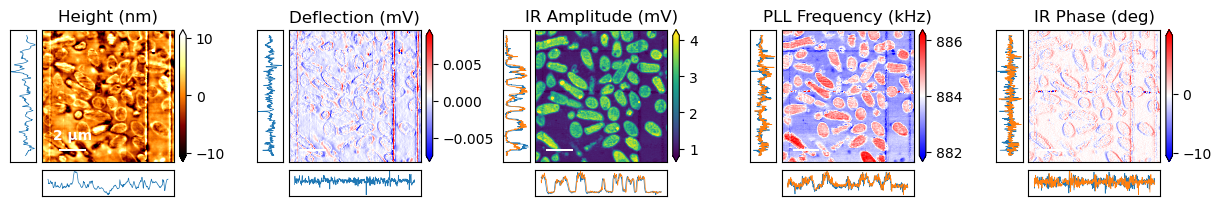

In [8]:
def plot_map_trace(hmap,hmap_r,ax_main ,ax_cb,ax_trace_vert,ax_trace_ho,show_sb_val,height_frac, cb_extend='both'):
    # m = aptwrapper.plot_map(
    #     hmap, ax=ax_main, show_sb_val=show_sb_val, colorbar=False, annotation=' '
    # )

    hmap = aptwrapper.default_flatten(hmap)
    extent = [hmap.X.min(), hmap.X.max(), hmap.Y.min(), hmap.Y.max()]
    m = ax_main.imshow(
        hmap.data, cmap=aptwrapper.default_cmap(hmap), 
        extent=extent, 
        vmin=np.percentile(hmap.data, 1), 
        vmax=np.percentile(hmap.data, 99)
    )
    aptwrapper.add_scalebar(ax_main, show_value=show_sb_val)
    ax_main.set(xticks=[], yticks=[])
    plt.gcf().colorbar(m, cax=ax_cb, extend=cb_extend)
    ax_main.set_title(aptwrapper.default_cblabel(hmap))

    line_i = int(np.floor(height_frac * hmap.shape[0]))
    ii = np.arange(hmap.shape[1])

    hmap_f = aptwrapper.default_flatten(hmap).data
    ax_trace_vert.plot(hmap_f[:, line_i], ii, lw=.5)
    ax_trace_ho.plot(hmap_f[line_i], lw=.5)
    if hmap_r is not None:
        hmap_rf = aptwrapper.default_flatten(hmap_r).data
        ax_trace_vert.plot(hmap_rf[:, line_i], ii, lw=.5)
        ax_trace_ho.plot(hmap_rf[line_i], lw=.5)

    for a in [ax_trace_ho, ax_trace_vert]:
        a.set(xticks=[], yticks=[])

def plot_iterations(doc, map_i, height_frac=.5):
    channels = [k for k in doc.HeightMaps if k.endswith(' ' +str(map_i))]

    # Sort channels in a desired order
    def sorter(x):
        for i, d in enumerate(['Height', 'Deflection', 'IR Amplitude', 'PLL Frequency', 'IR Phase']):
            if d in x: return i
        return 999
    channels = sorted(channels, key=sorter)

    # Define figure layout
    n = len(channels)
    fig = plt.figure(figsize=(15,2.5))
    gsi = GridSpec(1, n, figure=fig, wspace=.4)

    # Set up subplots
    for i, c in enumerate(channels):
        gsii = GridSpecFromSubplotSpec(2, 3, subplot_spec=gsi[i], wspace=.1, hspace=.1, width_ratios=[.2,1,.05], height_ratios=[1,.2])
        ax_main=plt.gcf().add_subplot(gsii[0,1])
        ax_cb=plt.gcf().add_subplot(gsii[0, 2])
        ax_trace_vert=plt.gcf().add_subplot(gsii[0,0])
        ax_trace_ho=plt.gcf().add_subplot(gsii[1,1])
        
        plot_map_trace(
            hmap=doc.HeightMaps[c],
            hmap_r=None if c + ' (1)' not in doc.HeightMaps else doc.HeightMaps[c + ' (1)'],
            # ax_main=fig.add_subplot().set_position([i,0,1,1]),
            ax_main=ax_main,
            ax_cb=ax_cb,
            ax_trace_vert=ax_trace_vert,
            ax_trace_ho=ax_trace_ho,
            show_sb_val=(i==0), 
            height_frac=height_frac
        )
        if i==0: leftmost_ax = ax_trace_vert

    _, _, w, h = ax_main.get_window_extent().bounds
    fig.set_size_inches(fig.get_figwidth(), fig.get_figheight() * w/h)
    return fig

plot_iterations(aptwrapper.read(metadata.iloc[0].folder + metadata.iloc[0].file), int(metadata.iloc[0].amp1625))
None

# Spectrum QC (definition)

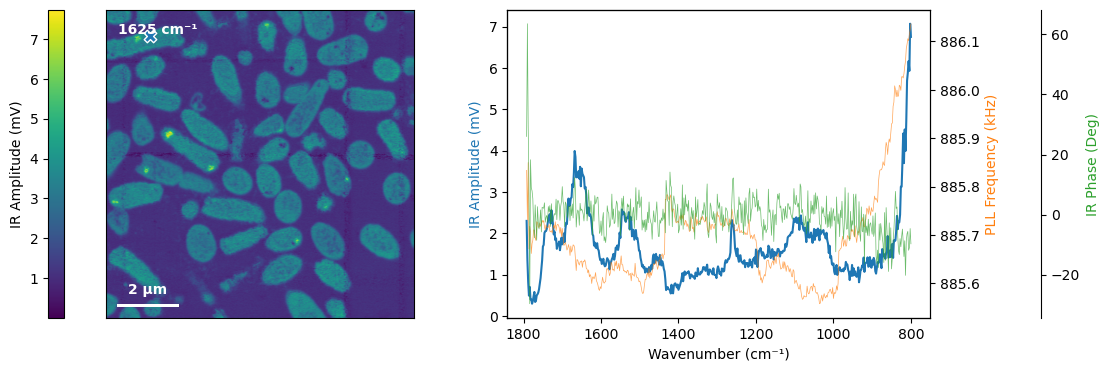

In [21]:
from utils import get_ref_map

def get_latest_map_before_spectrum(spectrum):
    path = spectrum.folder.item() + spectrum.file.item()
    doc = aptwrapper.read(path)
    timestamps = [
        v.TimeStamp.item()
        for k, v in doc.HeightMaps.items()
        if v.TimeStamp < spectrum.TimeStamp
    ]
    timestamps_with_multiple_maps = [
        t for t in set(timestamps) if timestamps.count(t) > 1
    ]
    t0 = max(timestamps_with_multiple_maps)

    # Try to find IR map at t0
    irmaps_t0 = [
        v
        for k, v in doc.HeightMaps.items()
        if 'IR Amp' in k and v.TimeStamp.item() == t0
    ]
    if len(irmaps_t0) > 0: return irmaps_t0[0]

    # Try to find any heightmap at t0
    maps_t0 = [
        v for k, v in doc.HeightMaps.items()
        if 'Height' in k and v.TimeStamp.item() == t0
    ]
    if len(maps_t0) > 0: return maps_t0[0]

    # Try to find any map at t0
    maps_at_t0 = [
        v for k, v in doc.HeightMaps.items()
        if v.TimeStamp.item() == t0
    ]
    if len(maps_at_t0) > 0: return maps_at_t0[0]
    raise Exception('No map found at t0')

def plot_spectrum_qc(spectrum):
    # Set up axes
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[1].invert_xaxis()
    tax = ax[1].twinx()
    ttax = ax[1].twinx()

    # Plot data
    try:
        ref_map = get_ref_map(spectrum, maps)
        aptwrapper.plot_map(ref_map, ax=ax[0], cmap='viridis', flatten=False, annotation='1625 cm⁻¹', cb_label='IR Amplitude (mV)')
    except Exception as e:
        ref_map = get_latest_map_before_spectrum(spectrum)
        aptwrapper.plot_map(ref_map, ax=ax[0])               
    
    aptwrapper.mark_location(spectrum, ax=ax[0])
    ax[1].plot(spectrum.v, spectrum['IR Amplitude (mV)'])
    tax.plot(  spectrum.v, spectrum['PLL Frequency (kHz)'], c='C1', lw=.5, alpha=.7)
    ttax.plot( spectrum.v, spectrum['IR Phase (Deg)'],      c='C2', lw=.5, alpha=.7)

    # Add labels
    ax[1].set_xlabel('Wavenumber (cm⁻¹)')
    ax[1].set_ylabel('IR Amplitude (mV)', color='C0')
    tax.set_ylabel('PLL Frequency (kHz)', color='C1')
    ttax.set_ylabel('IR Phase (Deg)', color='C2')

    # Adjust spine
    ttax.spines['right'].set_visible(True)
    ttax.spines['right'].set_position(('outward', 80))
    ttax.yaxis.set_label_position('right')
    ttax.yaxis.set_ticks_position('right')

plot_spectrum_qc(spectra.isel(si=0))

# Execute long-running tasks

In [10]:
from matplotlib.backends.backend_pdf import PdfPages

import os
output_directory = "../figures"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

with PdfPages('../figures/supp_irmaps_qc.pdf') as pdf:
    for i, r in metadata.iterrows():
        if not np.isnan(r.amp1625): 
            fig = plot_iterations(aptwrapper.read(r.folder + r.file), int(r.amp1625))
            fig.suptitle(f"dataset '{r.dataset_id}', 1625 cm⁻¹", y=1.2, weight='bold')
            pdf.savefig(bbox_inches='tight')
            plt.close()
        if not np.isnan(r.amp1650): 
            fig = plot_iterations(aptwrapper.read(r.folder + r.file), int(r.amp1650))
            fig.suptitle(f"dataset '{r.dataset_id}', 1650 cm⁻¹", y=1.2, weight='bold')
            pdf.savefig(bbox_inches='tight')
            plt.close()

In [23]:
with PdfPages('../figures/supp_spectra_qc.pdf') as pdf:
    for s in [spectra, spectra_vodd]:
        for i in range(len(s['IR Amplitude (mV)'])):
            spectrum = s.isel(si=i)
            plot_spectrum_qc(spectrum)
            plt.suptitle(f"dataset '{spectrum.dataset_id.item()}', label '{spectrum.Label.item()}'", weight='bold')
            pdf.savefig(bbox_inches='tight')
            plt.close()